In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [3]:
__author__ = "Sreejith Sreekumar"
__email__ = "sreekumar.s@husky.neu.edu"
__version__ = "0.0.1"

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.metrics import make_scorer
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

## cross validation
from  sklearn.linear_model import LassoCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

from xgboost import XGBClassifier
from sklearn.svm import SVR

from scipy import sparse as sp
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go


from sklearn.linear_model import LinearRegression

In [6]:
data_path = "../data/winemag-data_first150k.csv"
data = pd.read_csv(data_path)

In [7]:
data.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


__Visualization1: What is the average wine price per country?__

In [8]:
grouped_avg_price = data.groupby("country")["price"].mean().reset_index(name="average_price")
grouped_avg_price = grouped_avg_price.sort_values(by="average_price", ascending=False)
grouped_avg_price = grouped_avg_price.dropna()


_data = [go.Line(
            x=grouped_avg_price["country"],
            y=grouped_avg_price["average_price"]
    )]



layout = go.Layout(
    title='Average price of wine country-wise',
    
    xaxis=dict(
        title='Country',
        titlefont=dict(
            family='Lato',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Price of wine',
        titlefont=dict(
            family='Lato',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=_data, layout=layout)
py.iplot(fig, filename='price')

/usr/local/lib/python3.6/dist-packages/plotly/graph_objs/_deprecations.py:372: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




__Which country produces the most number of `unique` wines__

(What % of the unique wines are made by a country)

In [9]:
unique_wines = data.groupby(["variety","country"]).size().reset_index(name="count")
unique_wines = unique_wines[["variety","country"]]

In [10]:
wines_count = unique_wines.groupby("country").size().reset_index(name="count")
total_number_of_wines = sum(wines_count["count"])

In [11]:
# Number of unique wines in the dataset
len(data["variety"].unique())

632

__There are 632 unique wines in the dataset__

What % of all the unique wines are made by a country?

In [12]:
wines_count = wines_count.sort_values(by="count",ascending=False)

_data = [go.Bar(
            x=wines_count["country"],
            y=wines_count["count"]
    )]


layout = go.Layout(
    title='Number of unique wines available country-wise',
    
    xaxis=dict(
        title='Country',
        titlefont=dict(
            family='Lato',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Unique Wines Made',
        titlefont=dict(
            family='Lato',
            size=18,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=_data, layout=layout)
py.iplot(fig, filename='Number of unique wines')

__Write-up__ :

   To Do

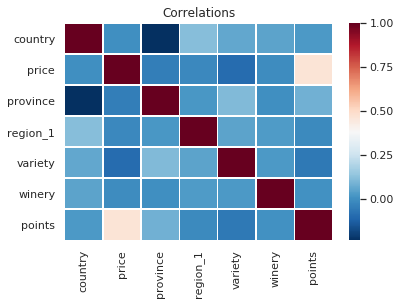

In [13]:
def encode_objects(df_):
    # we dont want the original data to be modified - using shallow copy
    df = df_.copy()
    for column in df.columns:
        if df.dtypes[column] == np.object:
            enc = LabelEncoder()
            df[column] = enc.fit_transform(df[column])
    return df

data_update = data[["country","description","designation","price","province","region_1","region_2","variety","winery","points"]]

correlation_inp = data_update[["country","price","province","region_1","variety","winery","points"]]
correlation_inp = correlation_inp.dropna()
data_ = encode_objects(correlation_inp)
correlations = data_.corr()

g1 = sns.heatmap(correlations, linewidths=.5, cmap = "RdBu_r")
plt.title("Correlations")

plt.show()

__region 2 has a lot of NaNs which are `not okay` for our  correlation calculations. So they've been taken out.__

In [14]:
features = ["country","description","price","province","region_1","variety","winery"]
target= 'points'

cols = ["country","description","price","province","region_1","variety","winery", "points"]

data_ = data[cols]
data_ = data_.dropna()

X = data_[features]
y = data_[target]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)

In [16]:
# process text data

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

description_train = vectorizer.fit_transform(X_train["description"])
description_test = vectorizer.transform(X_test["description"]) 

In [17]:
# one hot encoded columns from categorical features

countrycols = pd.get_dummies(X_train['country'])
provincecols = pd.get_dummies(X_train['province'])
regioncols = pd.get_dummies(X_train['region_1'])
varietycols =  pd.get_dummies(X_train['variety'])
winerycols = pd.get_dummies(X_train['winery'])



countrycols_test = pd.get_dummies(X_test['country'])
provincecols_test = pd.get_dummies(X_test['province'])
regioncols_test = pd.get_dummies(X_test['region_1'])
varietycols_test =  pd.get_dummies(X_test['variety'])
winerycols_test = pd.get_dummies(X_test['winery'])


In [18]:
#scaling numeric features
scaler = StandardScaler(copy=False)
price = pd.DataFrame(scaler.fit_transform(X_train[["price"]]), columns=["price"])
price_test = pd.DataFrame(scaler.transform(X_test[["price"]]), columns=["price"])

In [19]:
# joining categorical and numeric features
X_train = pd.concat([price, countrycols, provincecols, regioncols, varietycols, winerycols], axis=1)
X_test = pd.concat([price_test, countrycols_test, provincecols_test, regioncols_test, varietycols_test, winerycols_test], axis=1)

In [20]:
X_train = X_train.loc[:,~X_train.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

In [21]:
features_to_train = list(set(X_train.columns))
features_not_in_test = list(set(features_to_train) - set(X_test.columns))
for feature in features_not_in_test:
    X_test[feature] = 0

In [22]:
X_test = X_test[features_to_train]

In [23]:
X_train = sp.csr_matrix(X_train.values)
X_test = sp.csr_matrix(X_test.values)

In [24]:
print(X_train.shape)
print(X_test.shape)

(91514, 12835)
(22879, 12835)


In [25]:
X_train = sp.hstack([X_train, description_train])
X_test = sp.hstack([X_test, description_test])

In [25]:
import pickle

pickle1 = open("X_train.pickle","wb")
pickle.dump(X_train, pickle1)
pickle1.close()

pickle2 = open("X_test.pickle","wb")
pickle.dump(X_test, pickle2)
pickle2.close()

__Let us perform a simple linear regression as our baseline model__

In [26]:
lr_clf = LinearRegression().fit(X_train, y_train)

In [27]:
# Train accuracy and Test accuracy
lr_train_score = lr_clf.score(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)
#lr_varience = explained_variance_score(y_test, lr_pred)

print("MSE: ", lr_mse)
#print("Explained Varience Score: ", lr_r2)

MSE:  97.29835753175725


In [28]:
import pickle

pickle1 = open("lr_clf.pickle","wb")
pickle.dump(lr_clf, pickle1)
pickle1.close()

__Mean Squared Error:__ 105.24

__Now let's try XGBoost__

In [29]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [30]:
xgb_pred = xgb_clf.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mse

15.001966869181345

In [31]:
import pickle

pickle1 = open("xgb_clf.pickle","wb")
pickle.dump(xgb_clf, pickle1)
pickle1.close()

__Let's try SVR model for the regression__

In [32]:
svr_clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
svr_clf.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [33]:
svr_pred = svr_clf.predict(X_test)
svr_mse = mean_squared_error(y_test, svr_pred)
svr_mse

9.20836144678753

In [34]:
import pickle

pickle1 = open("svr_clf.pickle","wb")
pickle.dump(svr_clf, pickle1)
pickle1.close()

__Justification of algorithm choices__

ToDo


__Cross Validation for parameter selection__

The following parameters are to be tuned for the three classifiers used:

- Linear regression with L1 (Lasso) regularization (Ref:https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)   
    * Parameter(s): 
                    alpha – co-efficient of regularization term  
- XGBoost  (Ref: xgboost.cv - https://xgboost.readthedocs.io/en/latest/python/python_api.html)
    * Parameter(s): 
                    max_depth – Maximum tree depth for base learners.
                    learning_rate – Boosting learning rate (xgb’s “eta”)
                    n_estimators – Number of boosted trees to fit.
- Kernel type and 'c' value for the SVR model  (Ref. https://scikit-learn.org/stable/modules/grid_search.html)
    * Parameter(s): 
                    c – width of the decision boundary 
                    kernel – rbf, poly etc.


In [35]:
alphas = [0.005, 0.05, 0.5, 1.0, 5]

# lr_cv_clf = LassoCV(alphas=alphas, cv=10, n_jobs=-1).fit(X_train, y_train)
# lr_clf_pred = lr_cv_clf.predict(X_train)


# or load the saved model

lr_cv_clf_serialized = open("lr_cv_clf.pickle",'rb')
lr_cv_clf_ = pickle.load(lr_cv_clf_serialized)

In [41]:
lr_cv_clf_.mse_path_

array([[10.73992333, 10.9621676 , 10.73034955, 10.56735145, 10.92926707,
        10.97853574, 10.75894734, 10.79112262, 10.53711029, 10.90260388],
       [ 9.44808498,  9.51743258,  9.37817915,  9.2419539 ,  9.51536233,
         9.57135688,  9.42060504,  9.42624894,  9.22121609,  9.50954322],
       [ 8.86243776,  8.76364143,  8.55933215,  8.47065644,  8.69973076,
         8.78357182,  8.5629874 ,  8.61422283,  8.49501892,  8.97517112],
       [ 8.62961513,  8.40783133,  7.98463842,  7.94260075,  8.18640597,
         8.29009489,  7.9059341 ,  8.05103065,  8.03726805,  8.94392639],
       [ 6.05099954,  5.86467675,  5.56108954,  5.50195769,  5.72186975,
         5.75710158,  5.60735264,  5.62552793,  5.70134137,  6.23481536]])

In [36]:
# save if required

# import pickle

# pickle1 = open("lr_cv_clf.pickle","wb")
# pickle.dump(lr_cv_clf, pickle1)
# pickle1.close()

__Visualization for selection of best alpha for the lasso model__

Text(0.5, 1.0, 'Variation of MSE for varying alpha values')

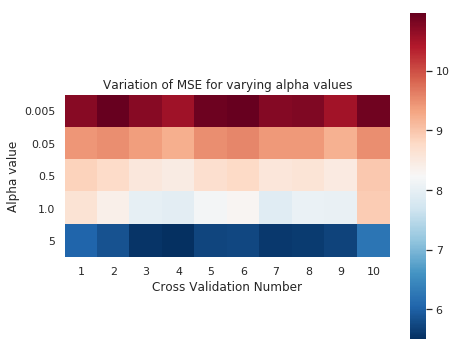

In [45]:
xticklabels = list(range(1,11,1))
yticklabels = alphas


f = plt.figure(figsize=(16, 6))
 
ax1 = f.add_subplot(121)
ax1 = sns.heatmap(lr_cv_clf_.mse_path_, 
                  square=True, 
                  xticklabels=xticklabels, 
                  yticklabels=yticklabels,
                  cmap="RdBu_r")

ax1.tick_params(axis='y', rotation=0)

ax1.set_ylabel("Alpha value")
ax1.set_xlabel("Cross Validation Number")        
ax1.set_title('Variation of MSE for varying alpha values')

__Using 0.005 as the optimal value for alpha, for Lasso Regularized Linear Regression Model__   ---- (1)

__XGBoost__

In [33]:
param_dist = {
                'n_estimators': [5, 10, 20, 30],
                'learning_rate': [0.01, 0.01, 0.1],
                'max_depth': [3, 4, 5, 6]
             }
                                  
xgb_cv_clf = GridSearchCV(XGBClassifier(), 
                         param_grid = param_dist, 
                         scoring = 'neg_mean_squared_error',
                         cv = 10,
                         n_jobs = -1)

xgb_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 20, 30], 'learning_rate': [0.01, 0.01, 0.1], 'max_depth': [3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [34]:
## save the classifier

import pickle

pickle1 = open("xgb_cv_clf.pickle","wb")
pickle.dump(xgb_cv_clf, pickle1)
pickle1.close()

In [35]:
param_dist = {
                'C': [0.1, 1, 10],
                'kernel': ['rbf','poly']
             }
                                  
svr_cv_clf = GridSearchCV(SVR(), 
                         param_grid = param_dist, 
                         scoring = 'neg_mean_squared_error',
                         cv = 10,
                         n_jobs = -1)

svr_cv_clf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
## save the classifier

import pickle

pickle1 = open("svr_cv_clf.pickle","wb")
pickle.dump(svr_cv_clf, pickle1)
pickle1.close()